<a href="https://colab.research.google.com/github/JEONSEHYEON/GwangjuAI_SGS/blob/main/safeware_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')
from scipy.signal import butter, lfilter, freqz
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
pd.set_option('display.max_rows',100)

In [ ]:
path = '/content/drive/MyDrive/sisfall_data/'
person = ['SA01','SA02','SA03','SA04','SA05','SA06','SA07','SA08','SA09','SA10','SA11','SA12','SA13','SA14','SA15','SA16','SE01','SE02','SE03','SE04','SE05','SE06','SE07','SE08','SE09'] # 학습

person2 = ['SA17','SA18','SA19','SA20','SE06','SE10','SE11','SE12'] # 테스트
# person = ['data1','data3','data5','data7','data9','data11','data13','data15','data17','data19','data21','data23']
# person = os.listdir(path)
# person.pop(0)

In [ ]:
# dailies = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
#            'D16', 'D17', 'D18', 'D19']
dailies = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10'] # 다 가지고 오면 너무 데이터가 커서 ram 이 못받아들임 그래서 10까지만 가져옴
falls = ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']
# falls = ['F01', 'F02', 'F03', 'F04']
trials = ['R01', 'R02','R03','R04','R05']



In [ ]:

# Filter requirements.
order = 4
fs = 200.0  # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz


# From??????
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def printer(df, min_max=True, range=[0,3000], *args): # 시각화
    idx = {}
    if min_max:
        x = df.drop(['activity','person'], axis=1).astype('float64')
        k = (x - x.min()) / (x.max() - x.min())
        for w in args:
            plt.plot(k[w],label=w)
            idx[w] = df[w][df[w] == df[w].max()].index.values
        plt.title(f'person:{df.person[0]}  ,  activity:{df.activity[0]}')
        plt.xlim(range)
        plt.legend()
        plt.show()
        for w in idx:
            print(f'{w} : {idx[w]}')
    else:
        for w in args:
            plt.plot(df[w],label=w)
        plt.title(df.activity[0])
        plt.xlim(range)
        plt.legend()
        plt.show()

In [ ]:
printer(fall_list[0], True, [0,3000], 'vm2', 'g_sum')

In [ ]:
def preprocess(person): # 정확히는 get_data()
    subjectList = []
    adl_list = []
    fall_list = []
    for man in person:
        a = pd.read_csv(path + f'{man}.csv')
        df = a[['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'subject', 'activity', 'trial']]
    #     df['ADXL_x'] *= (32/8192)
    #     df['ADXL_y'] *= (32/8192)
    #     df['ADXL_z'] *= (32/8192)
        subjectList.append(df)
    for s in subjectList:
        for d in dailies:
            tempdf = s[s['activity'] == d]
            adl_list.append(tempdf)

        for f in falls:
            tempdf = s[s['activity'] == f]
            fall_list.append(tempdf)
            
    return fall_list, adl_list
    

In [ ]:
def preprocess2(df): # 특성 추출
    df_list = []
    rol_val = 200
    for my_df in df:
        for trial in trials:
            trial_df = my_df[my_df['trial'] == trial]
            if len(trial_df) == 0:
                continue
            trial_df.reset_index(inplace=True)
            tempdf = pd.DataFrame()
            tempdf['ax'], tempdf['ay'], tempdf['az'] = trial_df['ADXL_x'], trial_df['ADXL_y'], trial_df['ADXL_z']
            tempdf = tempdf.reset_index(drop=True)
            tempdf['fx'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_x'], cutoff, fs, order))
            tempdf['fy'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_y'], cutoff, fs, order))
            tempdf['fz'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_z'], cutoff, fs, order))
            tempdf['vs'] = np.sqrt(tempdf['ax'] ** 2 + tempdf['ay'] ** 2 + tempdf['az'] ** 2)
            tempdf['vm2'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fy'] ** 2 + tempdf['fz'] ** 2)

            tempdf['bx'] = tempdf['fx'].diff()
            tempdf['by'] = tempdf['fy'].diff()
            tempdf['bz'] = tempdf['fz'].diff()
            tempdf['diff_sum'] = np.sqrt(tempdf['bx'] ** 2 + tempdf['by'] ** 2 + tempdf['bz'] ** 2)
            tempdf['activity'] = trial_df['activity']
            tempdf['person'] = trial_df['subject']
            tempdf['gx'], tempdf['gy'], tempdf['gz'] = trial_df['ITG_x'], trial_df['ITG_y'], trial_df['ITG_z']
            tempdf['g_fx'] = pd.Series(butter_lowpass_filter(tempdf['gx'], cutoff, fs, order))
            tempdf['g_fy'] = pd.Series(butter_lowpass_filter(tempdf['gy'], cutoff, fs, order))
            tempdf['g_fz'] = pd.Series(butter_lowpass_filter(tempdf['gz'], cutoff, fs, order))
            tempdf['g_sum'] = np.sqrt(tempdf['g_fx'] ** 2 + tempdf['g_fy'] ** 2 + tempdf['g_fz'] ** 2)


            #Rolling standard deviations
            tempdf['bx_std'] = tempdf['bx'].rolling(rol_val,min_periods = 1).std()
            tempdf['by_std'] = tempdf['by'].rolling(rol_val,min_periods = 1).std()
            tempdf['bz_std'] = tempdf['bz'].rolling(rol_val,min_periods = 1).std()
            tempdf['fx_std'] = tempdf['fx'].rolling(rol_val,min_periods = 1).std()
            tempdf['fy_std'] = tempdf['fy'].rolling(rol_val,min_periods = 1).std()
            tempdf['fz_std'] = tempdf['fz'].rolling(rol_val,min_periods = 1).std()
            tempdf['gx_std'] = tempdf['gx'].rolling(rol_val,min_periods = 1).std()
            tempdf['gy_std'] = tempdf['gy'].rolling(rol_val,min_periods = 1).std()
            tempdf['gz_std'] = tempdf['gz'].rolling(rol_val,min_periods = 1).std()

            # had to make versions of this to put into sliding window, will change once I
            # confirm they're the same as the others below
            #C8
            tempdf['horiz_std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fz_std'] ** 2)
            #C2
            tempdf['horiz_vector_mag9'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)
            tempdf['std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fy_std'] ** 2 + tempdf['fz_std'] ** 2)
            #C9
            tempdf['horiz_std_mag2'] = np.sqrt(tempdf['bx_std'] ** 2 + tempdf['bz_std'] ** 2)
            tempdf['gyro_horiz_std_mag'] = np.sqrt(tempdf['gx_std'] ** 2 + tempdf['gz_std'] ** 2)
            tempdf['gyro_vector_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gy'] ** 2 + tempdf['gz'] ** 2)
            tempdf['gyro_horiz_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gz'] ** 2)
            # C2
            tempdf['horiz_mag'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)

            df_list.append(tempdf.fillna(0))
    return df_list

In [ ]:
def labeling(fall_list,adl_list, standard , min_max , check_list): # 라벨링 *checkk_list : 사용할 특성(컬럼)
    adl_df = []
    fall_df = []

    for df in fall_list:
        df = df.loc[:,check_list]
        if min_max:
            df = (df - df.min()) / (df.max() - df.min()) # min max 정규화

        k = df[standard].idxmax()
        fall = df.loc[k - 160 : k] # vm 이 최고점을 찍은 순간의 0.8초 전까지를 fall 로 라벨렝하겠다. 그 부분만 가져와서 fall df에 append
        fall['label'] = 1
        fall_df.append(fall)
    
    for df in adl_list:
        df = df.loc[200:,check_list] 
        if min_max:
            df = (df - df.min()) / (df.max() - df.min())
        df['label'] = 0 # adl 로 그냥 뭐.. 0으로 append
        adl_df.append(df)

    return fall_df, adl_df

In [ ]:
# 200은 1초에 200개씩 row가 찍힘
# 60이 0.3 초. 0.3 초씩 끊어서 가져옴. 이 0.3초의 데이터가 윈도우 사이즈

def windowing(fall_df,adl_df , WINDOWSIZE):
    x = []
    y = []
    for df in fall_df: # fall_df에는 0.8초에 대한 데이터가 들어가 있음
        for i in range(len(df) - WINDOWSIZE):
            df_x = df.drop('label',axis=1).iloc[i : i+ WINDOWSIZE]
            df_y = df['label'].iloc[i+ WINDOWSIZE]
            x.append(df_x)
            y.append(df_y)
    for df in adl_df:
        count = 0
        for i in range(120,len(df) - WINDOWSIZE,20):
            count += 1
            df_x = df.drop('label',axis=1).iloc[i : i+ WINDOWSIZE]
            df_y = df['label'].iloc[1]
            x.append(df_x)
            y.append(df_y)
            if count > 120:
                break

    x = np.array(x) 
    y = np.array(y)
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state = 0)
    return x_train, x_valid, y_train, y_valid

In [ ]:
WINDOWSIZE = 60

In [ ]:
# preprocess
fall_list, adl_list = preprocess(person)
fall_list = preprocess2(fall_list)
adl_list = preprocess2(adl_list)

In [ ]:
checkList = checkList = [
'std_mag9',
'horiz_std_mag2',
'gyro_vector_mag',
'gyro_horiz_mag',
'vm2'
]

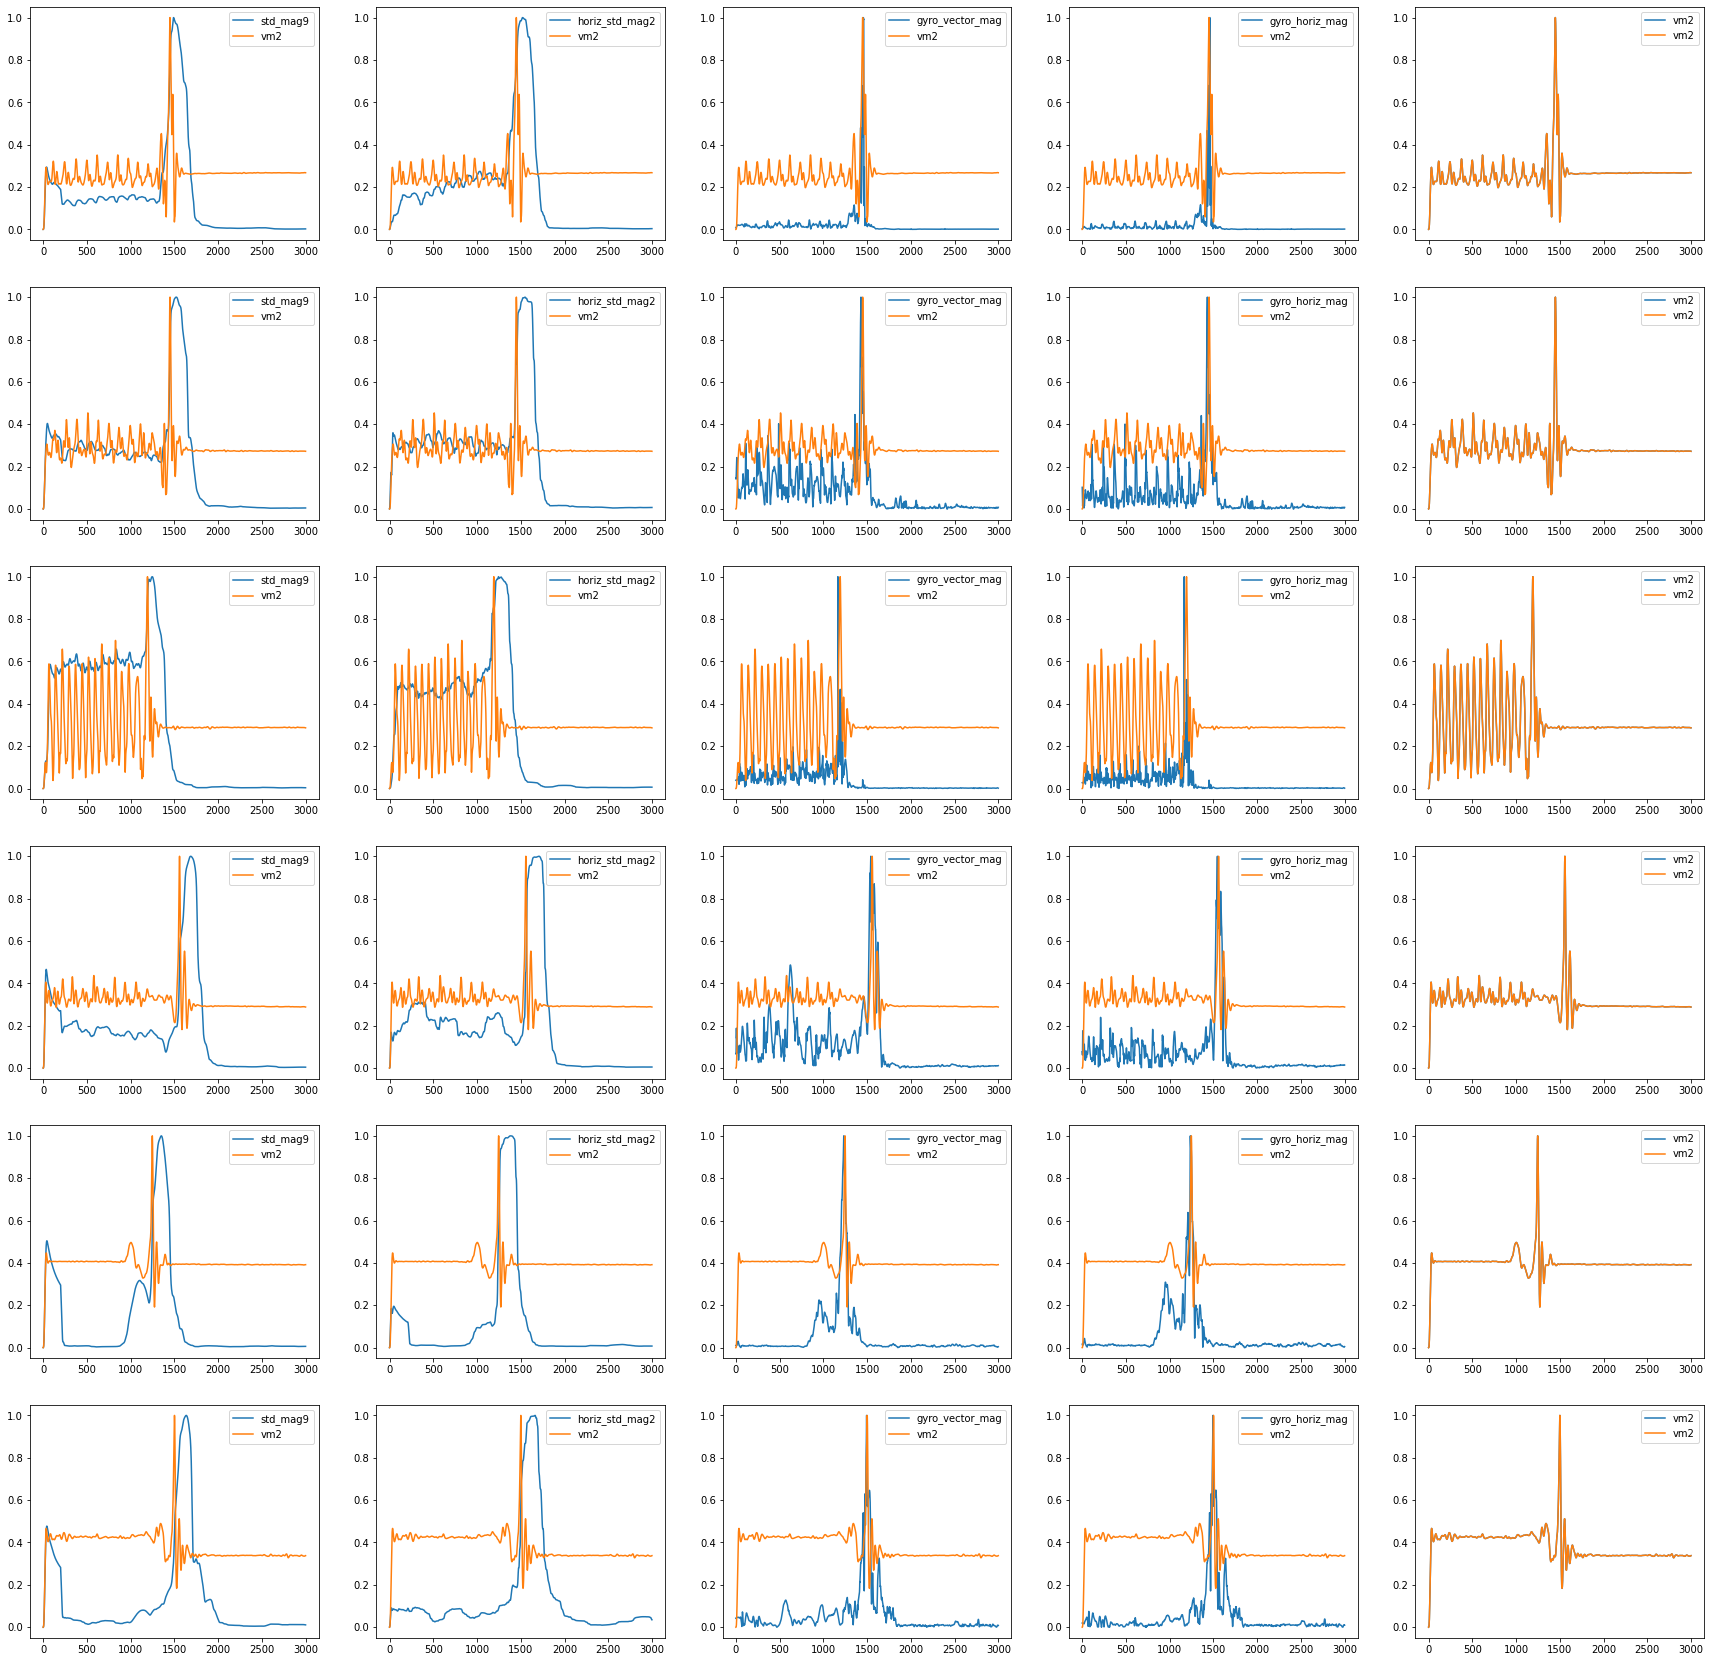

In [ ]:
count = 0

fig, ax = plt.subplots(6,5,figsize=(30,30))
for k in range(0, 60, 10):
    count2 = 0
    df = fall_list[k][checkList]
    df = (df - df.min()) / (df.max() - df.min())
    for i in checkList:

        ax[count,count2].plot(df[i], label=i)
        ax[count,count2].plot(df['vm2'] ,label = 'vm2')
        ax[count,count2].legend()
        count2 += 1
    count += 1

plt.show()


In [ ]:
fall_df, adl_df = labeling(fall_list,adl_list,'vm2',1, ['g_sum','std_mag9','vm2','horiz_std_mag2']) # 최종적으로 이 4개가 최종 특성

In [ ]:
x_train, x_valid, y_train, y_valid = windowing(fall_df , adl_df, 60)

In [ ]:
model = tf.keras.models.Sequential([
    # 1차원 feature map 생성
#     tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#            padding="causal",
#            activation="relu",dff
#            input_shape=[WINDOW_SIZE, 4]),
    # LSTM
    # 0.3초의 데이터와 특성 4개가 input
    tf.keras.layers.LSTM(128,input_shape=[WINDOWSIZE, 4], activation='tanh', return_sequences=True), # return_sequences 를 True 로 줌으로써 각 노드마다 아웃풋이 나오게 함
    tf.keras.layers.LSTM(64,  return_sequences=True,dropout=0.2 ),  # 과적합 방지
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"), # 최종 출력이 0또는 1로
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')
early_stop = EarlyStopping(monitor='val_loss', patience=30)
filename = os.path.join(path + 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
5390/5392 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.8973
Epoch 00001: val_loss improved from inf to 0.21081, saving model to /content/drive/MyDrive/sisfall_data/tmp_checkpoint.h5
5392/5392 [==============================] - 66s 11ms/step - loss: 0.2567 - accuracy: 0.8973 - val_loss: 0.2108 - val_accuracy: 0.9126
Epoch 2/100
5390/5392 [============================>.] - ETA: 0s - loss: 0.1908 - accuracy: 0.9245
Epoch 00002: val_loss improved from 0.21081 to 0.17302, saving model to /content/drive/MyDrive/sisfall_data/tmp_checkpoint.h5
5392/5392 [==============================] - 59s 11ms/step - loss: 0.1907 - accuracy: 0.9245 - val_loss: 0.1730 - val_accuracy: 0.9321
Epoch 3/100
5388/5392 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9377
Epoch 00003: val_loss improved from 0.17302 to 0.14262, saving model to /content/drive/MyDrive/sisfall_data/tmp_checkpoint.h5
5392/5392 [==============================] - 59s 11ms/step 

In [ ]:
model = keras.models.load_model(path + 'tmp_checkpoint.h5')

In [ ]:
score = model.evaluate(x_train,y_train)
print(score[1])
print(score[0])
# p = pd.DataFrame(pre.round())
# p
# x = pd.DataFrame(y_train)
# t = pd.concat([p,x],axis=1)
# (t.iloc[:,1] + t.iloc[:,0]).value_counts()

5392/5392 [==============================] - 26s 5ms/step - loss: 0.0061 - accuracy: 0.9984
0.9983713030815125
0.006082640495151281


In [ ]:
fall_list, adl_list = preprocess(person2)
fall_list = preprocess2(fall_list)
adl_list = preprocess2(adl_list)

In [ ]:
##test data
fall_df = []
adl_df = []
for df in fall_list:
    df = df[['g_sum','std_mag9','vm2','horiz_std_mag2']]
    df = (df - df.min()) / (df.max() - df.min())
    df['label'] = 0
    k = df.vm2.idxmax()
    df['label'].loc[k-100:k] = 1
    df = df.loc[k-160:k]
    fall_df.append(df)
for df in adl_list:
    df = df[['g_sum','std_mag9','vm2','horiz_std_mag2']]
    df = (df - df.min()) / (df.max() - df.min())
    df['label'] = 0
    df = df.loc[200:400]
    adl_df.append(df)

test_x = []
test_y = []
WINDOWSIZE = 60
for df in fall_df:
    for i in range(len(df) - WINDOWSIZE):
        df_x = df.drop('label',axis=1).iloc[i : i+ WINDOWSIZE]
        df_y = df['label'].iloc[i+WINDOWSIZE]
        test_x.append(df_x)
        test_y.append(df_y)

for df in adl_df:
    for i in range(0, len(df) - WINDOWSIZE):
        df_x = df.drop('label',axis=1).iloc[i : i+ WINDOWSIZE]
        df_y = df['label'].iloc[i+WINDOWSIZE]
        test_x.append(df_x)
        test_y.append(df_y)

np_x = np.array(test_x)
np_y = np.array(test_y)
    

In [ ]:
score = model.evaluate(np_x,np_y)


2261/2261 [==============================] - 11s 5ms/step - loss: 0.2791 - accuracy: 0.9509


In [ ]:
score

[0.2791072428226471, 0.9508557319641113]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_hat = model.predict(np_x).round()

print(accuracy_score(np_y, y_hat))
print(recall_score(np_y, y_hat))
print(precision_score(np_y, y_hat))
print(f1_score(np_y, y_hat))

0.950855705161879
0.9246186780840246
0.9790881527868295
0.951074166334072
